In [1]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

c:\Users\USER\Documents\kaist 세미나\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Download census-income dataset

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'census-income'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [3]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, out.as_posix())

# Load data and split

In [4]:
train = pd.read_csv(out)
target = ' <=50K'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

# Simple preprocessing

Label encode categorical features and fill empty cells.

In [5]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

39 73
 State-gov 9
 Bachelors 16
 13 16
 Never-married 7
 Adm-clerical 15
 Not-in-family 6
 White 5
 Male 2
 2174 119
 0 92
 40 94
 United-States 42
 <=50K 2
Set 3


In [6]:
# check that pipeline accepts strings
train.loc[train[target]==0, target] = "wealthy"
train.loc[train[target]==1, target] = "not_wealthy"

# Define categorical features for categorical embeddings

In [7]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]


# Network parameters

In [8]:
clf = TabNetClassifier(cat_idxs=cat_idxs,
                       cat_dims=cat_dims,
                       cat_emb_dim=1,
                       optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":50, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax' # "sparsemax"
                      )

Device used : cpu


# Training

In [9]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [10]:
max_epochs = 1000 if not os.getenv("CI", False) else 2

In [11]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['auc'],
    max_epochs=max_epochs , patience=20,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False
) 

epoch 0  | loss: 0.66602 | train_auc: 0.773   | valid_auc: 0.77663 |  0:00:01s
epoch 1  | loss: 0.50993 | train_auc: 0.82958 | valid_auc: 0.83751 |  0:00:03s
epoch 2  | loss: 0.4648  | train_auc: 0.85134 | valid_auc: 0.85521 |  0:00:04s
epoch 3  | loss: 0.44728 | train_auc: 0.8694  | valid_auc: 0.87127 |  0:00:06s
epoch 4  | loss: 0.42407 | train_auc: 0.88256 | valid_auc: 0.88076 |  0:00:08s
epoch 5  | loss: 0.41091 | train_auc: 0.89309 | valid_auc: 0.88615 |  0:00:10s
epoch 6  | loss: 0.40226 | train_auc: 0.89976 | valid_auc: 0.8931  |  0:00:11s
epoch 7  | loss: 0.39131 | train_auc: 0.90552 | valid_auc: 0.89833 |  0:00:13s
epoch 8  | loss: 0.38404 | train_auc: 0.90739 | valid_auc: 0.90222 |  0:00:15s
epoch 9  | loss: 0.37373 | train_auc: 0.91188 | valid_auc: 0.90752 |  0:00:17s
epoch 10 | loss: 0.37088 | train_auc: 0.91213 | valid_auc: 0.90787 |  0:00:19s
epoch 11 | loss: 0.35714 | train_auc: 0.91386 | valid_auc: 0.91015 |  0:00:20s
epoch 12 | loss: 0.35333 | train_auc: 0.91614 | vali

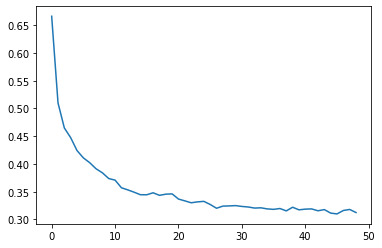

In [12]:
# plot losses
plt.plot(clf.history['loss'])

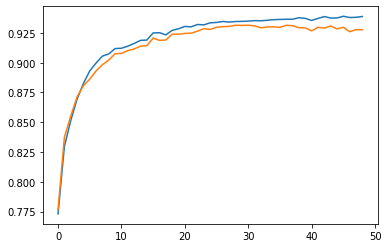

In [13]:
# plot auc
plt.plot(clf.history['train_auc'])
plt.plot(clf.history['valid_auc'])

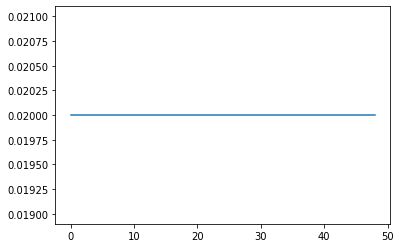

In [14]:
# plot learning rates
plt.plot(clf.history['lr'])

## Predictions

In [15]:
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)


preds_valid = clf.predict_proba(X_valid)
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=y_valid)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_auc}")

BEST VALID SCORE FOR census-income : 0.9314577220336382
FINAL TEST SCORE FOR census-income : 0.9261729429740958


In [16]:
# check that best weights are used
assert np.isclose(valid_auc, np.max(clf.history['valid_auc']), atol=1e-6)

In [17]:
clf.predict(X_test)

array(['not_wealthy', 'not_wealthy', 'wealthy', ..., 'not_wealthy',
       'wealthy', 'not_wealthy'], dtype='<U11')

# Save and load Model

In [18]:
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [19]:
# define new model with basic parameters and load state dict weights
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)

Device used : cpu
Device used : cpu


In [20]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_test_auc = roc_auc_score(y_score=loaded_preds[:,1], y_true=y_test)

print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_auc}")

FINAL TEST SCORE FOR census-income : 0.9261729429740958


In [21]:
assert(test_auc == loaded_test_auc)

In [22]:
loaded_clf.predict(X_test)

array(['not_wealthy', 'not_wealthy', 'wealthy', ..., 'not_wealthy',
       'wealthy', 'not_wealthy'], dtype='<U11')

# Global explainability : feat importance summing to 1

In [23]:
clf.feature_importances_

array([0.08459326, 0.02796824, 0.01792044, 0.06355008, 0.11800552,
       0.13948778, 0.089413  , 0.06439441, 0.00286478, 0.05444782,
       0.21340938, 0.02658093, 0.07236871, 0.02499566])

# Local explainability and masks

In [24]:
explain_matrix, masks = clf.explain(X_test)

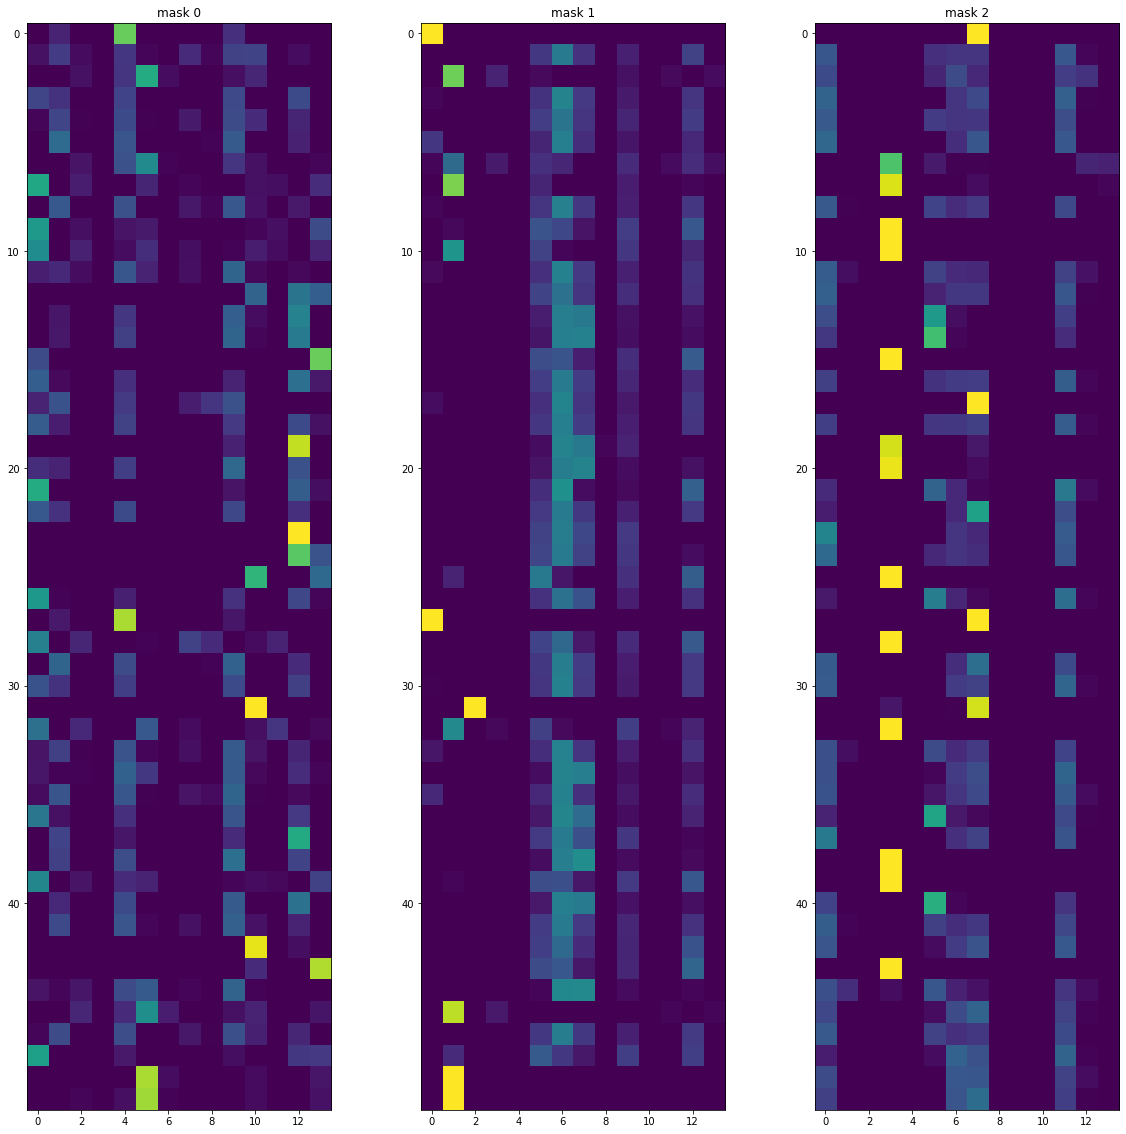

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")


# XGB

In [26]:
from xgboost import XGBClassifier

clf_xgb = XGBClassifier(max_depth=8,
    learning_rate=0.1,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='binary:logistic',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

clf_xgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=40,
        verbose=10)

[0]	validation_0-error:0.137224
Will train until validation_0-error hasn't improved in 40 rounds.
[10]	validation_0-error:0.129152
[20]	validation_0-error:0.126669
[30]	validation_0-error:0.124806
[40]	validation_0-error:0.124806
[50]	validation_0-error:0.124185
[60]	validation_0-error:0.124185
[70]	validation_0-error:0.124185
[80]	validation_0-error:0.124495
[90]	validation_0-error:0.123254
[100]	validation_0-error:0.122012
[110]	validation_0-error:0.121701
[120]	validation_0-error:0.122012
[130]	validation_0-error:0.122322
[140]	validation_0-error:0.122943
Stopping. Best iteration:
[103]	validation_0-error:0.12108



XGBClassifier(max_depth=8, n_estimators=1000, n_jobs=-1, subsample=0.7,
              verbosity=0)

In [27]:
preds = np.array(clf_xgb.predict_proba(X_valid))
valid_auc = roc_auc_score(y_score=preds[:,1], y_true=y_valid)
print(valid_auc)

preds = np.array(clf_xgb.predict_proba(X_test))
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)
print(test_auc)

0.9335963387010509
0.9243623615745875
